# AI - FasterRCNN Train
https://www.kaggle.com/tomchaniii/pytorch-starter-fasterrcnn-inference


In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [2]:
# Download TorchVision repo to use some files from
# references/detection
!git clone https://github.com/pytorch/vision.git && cd vision && git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./
!rm -rf vision

Cloning into 'vision'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 10661 (delta 29), reused 27 (delta 12), pack-reused 10591
Receiving objects: 100% (10661/10661), 11.93 MiB | 20.63 MiB/s, done.
Resolving deltas: 100% (7402/7402), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [3]:
!pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-2k4q0zsv
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-2k4q0zsv
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=279389 sha256=fe249d606b10cf6523c2ace7063b9e4eedc5263ff31d18131492891cb979b521
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ighco_f/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools


In [4]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [5]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [6]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-500:]
train_ids = image_ids[:-500]

In [7]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [8]:
valid_df.shape, train_df.shape

((17940, 8), (129853, 8))

In [9]:
import os
from PIL import Image
import math

class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None, noise=0, size_ratio=1):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.noise = noise
        self.size_ratio = size_ratio

    def __getitem__(self, index: int):
        
        if self.noise > 0:
            is_noise = index % 2
            index = math.floor(index / 2)

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        image = Image.open(os.path.join(self.image_dir, f'{image_id}.jpg')).convert("RGB")
        image = image.resize((round(image.width * self.size_ratio), round(image.height * self.size_ratio)))
        
        if self.noise > 0:
            if is_noise > 0:
                noise_image = Image.effect_noise(image.size, 127).convert("RGB")
                image = Image.blend(image, noise_image, self.noise)
                

        boxes = records[['x', 'y', 'w', 'h']].values
        
        boxes[:, 2] = np.clip(np.round((boxes[:, 0] + boxes[:, 2]) * self.size_ratio), 0, image.width)
        boxes[:, 3] = np.clip(np.round((boxes[:, 1] + boxes[:, 3]) * self.size_ratio), 0, image.height)
        boxes[:, 0] = np.clip(np.round(boxes[:, 0] * self.size_ratio), 0, image.width)
        boxes[:, 1] = np.clip(np.round(boxes[:, 1] * self.size_ratio), 0, image.height)
        
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = torch.as_tensor(boxes, dtype=torch.int64)
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self) -> int:
        if self.noise > 0:
            return self.image_ids.shape[0] * 2
        else:
            return self.image_ids.shape[0]

In [10]:
# helper functions for data augmentation / transformation
from engine import train_one_epoch, evaluate
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


# Create the model

In [11]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [12]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [13]:
import utils

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_transform(train=True), noise=0.2, size_ratio=1)
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_transform(train=False))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

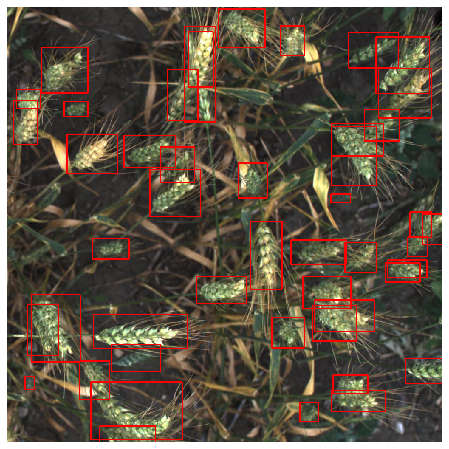

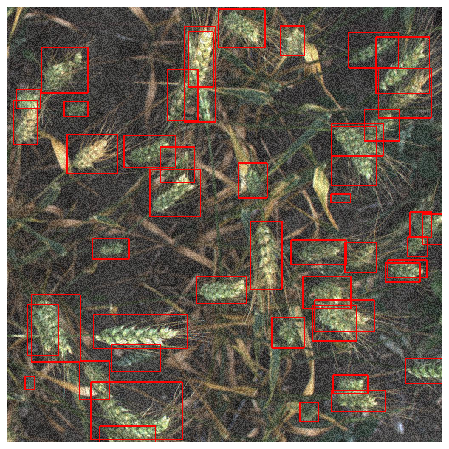

In [14]:
sample, target = train_dataset[0]
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sample = sample.permute(1,2,0).cpu().numpy()
boxes = target['boxes'].data.cpu().numpy().astype(np.int32)

sample = cv2.UMat(sample).get()

for box in boxes:
    cv2.rectangle(
        sample, 
        (box[0], box[1]), 
        (box[2], box[3]),
        (220, 0, 0), 2)

ax.set_axis_off()
ax.imshow(sample)

sample, target = train_dataset[1]
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sample = sample.permute(1,2,0).cpu().numpy()
boxes = target['boxes'].data.cpu().numpy().astype(np.int32)

sample = cv2.UMat(sample).get()

for box in boxes:
    cv2.rectangle(
        sample, 
        (box[0], box[1]), 
        (box[2], box[3]),
        (220, 0, 0), 2)

ax.set_axis_off()
ax.imshow(sample)

In [15]:
#for gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

# Train

In [16]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00349, momentum=0.9, weight_decay=0.0004)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 8

In [17]:
import sys
sys.path.insert(0, "/kaggle/working")

from engine import train_one_epoch, evaluate

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=20)
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
        
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

Epoch: [0]  [  0/360]  eta: 1:35:57  lr: 0.000013  loss: 4.9157 (4.9157)  loss_classifier: 0.6449 (0.6449)  loss_box_reg: 0.3230 (0.3230)  loss_objectness: 3.6622 (3.6622)  loss_rpn_box_reg: 0.2856 (0.2856)  time: 15.9935  data: 10.8431  max mem: 11464
Epoch: [0]  [ 20/360]  eta: 0:21:02  lr: 0.000207  loss: 1.6751 (2.6253)  loss_classifier: 0.5869 (0.5874)  loss_box_reg: 0.3909 (0.3760)  loss_objectness: 0.4977 (1.4527)  loss_rpn_box_reg: 0.2038 (0.2092)  time: 3.0997  data: 0.7644  max mem: 11729
Epoch: [0]  [ 40/360]  eta: 0:17:33  lr: 0.000402  loss: 1.4039 (2.0377)  loss_classifier: 0.4901 (0.5350)  loss_box_reg: 0.4514 (0.4127)  loss_objectness: 0.2724 (0.8893)  loss_rpn_box_reg: 0.1928 (0.2006)  time: 2.8469  data: 0.5297  max mem: 11729
Epoch: [0]  [ 60/360]  eta: 0:15:36  lr: 0.000596  loss: 1.2321 (1.7715)  loss_classifier: 0.4081 (0.4941)  loss_box_reg: 0.4519 (0.4260)  loss_objectness: 0.1835 (0.6571)  loss_rpn_box_reg: 0.1790 (0.1942)  time: 2.7795  data: 0.5177  max mem: 

In [18]:
# save model
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

In [19]:
#remove downloaded modules
!rm utils.py
!rm transforms.py
!rm coco_eval.py
!rm engine.py
!rm coco_utils.py